In [317]:
import cv2
import numpy as np
import imutils
from utils.cttutils import displayImage
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours

In [318]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def DoGrayscaleAndBlur(image):
    # grayscale and blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    return gray

def calculateMetric(knownValue, img, bg_img, metric, th):
    diff = cv2.absdiff(bg_img, img)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    imask =  mask>th
    canvas = np.zeros_like(img, np.uint8)
    canvas[:] = 255
    canvas[imask] = img[imask]
    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    result = DoGrayscaleAndBlur(canvas)
    edged = cv2.Canny(result, 180, 200)
    edged = cv2.dilate(edged, None, iterations=2)
    edged = cv2.erode(edged, None, iterations=1)
     # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]

    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts, method='left-to-right')
    
    # get areas for all contours
    areas = []
    for c in cnts:
        a = cv2.contourArea(c)
        areas.append(a)
    
    areas = np.array(areas)
    cnts = np.array(cnts)

    # remove small contours
    cnts = cnts[np.where(areas >= 600)[0]]
    
    # remove areas of removed contours
    areas = areas[np.where(areas >= 600)[0]]
    
    # loop over the contours individually and get bounding boxes
    boxes = []
    for c in cnts:
    
        # compute the rotated bounding box of the contour
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box) 
        box = np.array(box, dtype="int")
 
        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        boxes.append(box)

    boxes = np.array(boxes)
    object_sizes = []

    pixelsPerMetric = None
    for box in boxes:
        # unpack the ordered bounding box, then compute the midpoint
        # between the top-left and top-right coordinates, followed by
        # the midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)
 
        # compute the midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-righ and bottom-right
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
 
        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
 
        # if the pixels per metric has not been initialized, then
        # compute it as the ratio of pixels to supplied metric
        # (in this case, inches)
        if pixelsPerMetric is None:
            if metric == 'height':
                pixelsPerMetric = dA / knownValue
            else:
                pixelsPerMetric = dB / knownValue

        #object_sizes.append([box, dimB, dimA])

    return pixelsPerMetric, boxes

## Side Processing

In [319]:
side1 = cv2.imread("calibration/cab1.jpg")
side2 = cv2.imread("calibration/cab2.jpg")
bgside = cv2.imread("calibration/bg_side.jpg")

width = 1000
height = 1000
startX = 1200
startY = 1000

def crop(image):
    return image[startY:startY+height, startX:startX+width]

side1 = crop(side1)
side2 = crop(side2)
bgside = crop(bgside)

hppm1, boxes_s1 = calculateMetric(9, side1, bgside, 'height', 100)
hppm2, boxes_s2 = calculateMetric(9, side2, bgside, 'height', 70)

In [320]:
print(hppm1)
print(hppm2)

16.444819815535592
19.336206683030902


In [321]:
top1 = cv2.imread("calibration/cabt1.jpg")
top2 = cv2.imread("calibration/cabt2.jpg")
bgtop = cv2.imread("calibration/bg_top.jpg")

top1 = imutils.rotate(top1,180)
top2 = imutils.rotate(top2, 180)
bgtop = imutils.rotate(bgtop, 180)

width = 1050
height = 1080
startX = 550
startY = 450

def crop(image):
    return image[startY:startY+height, startX:startX+width]

top1 = crop(top1)
top2 = crop(top2)
bgtop = crop(bgtop)

wppm1, boxes_t1 = calculateMetric(26, top1, bgtop, 'width', 70)
wppm2, boxes_t2 = calculateMetric(26, top2, bgtop, 'width', 70)

b = boxes_t1[0]
x1 = top1.shape[0]- np.max(b[:,1])
b = boxes_t2[0]
x2 = top2.shape[0]- np.max(b[:,1])

In [322]:
side_b = (hppm2*x1 - hppm1*x2) / (-x2 + x1)
side_m = (hppm1 - side_b) / x1

In [323]:
print(side_b,side_m)

20.3059886137 -0.0179589246428


## END OF CALIBRATION OF SIDE CAMERA

## Top Processing

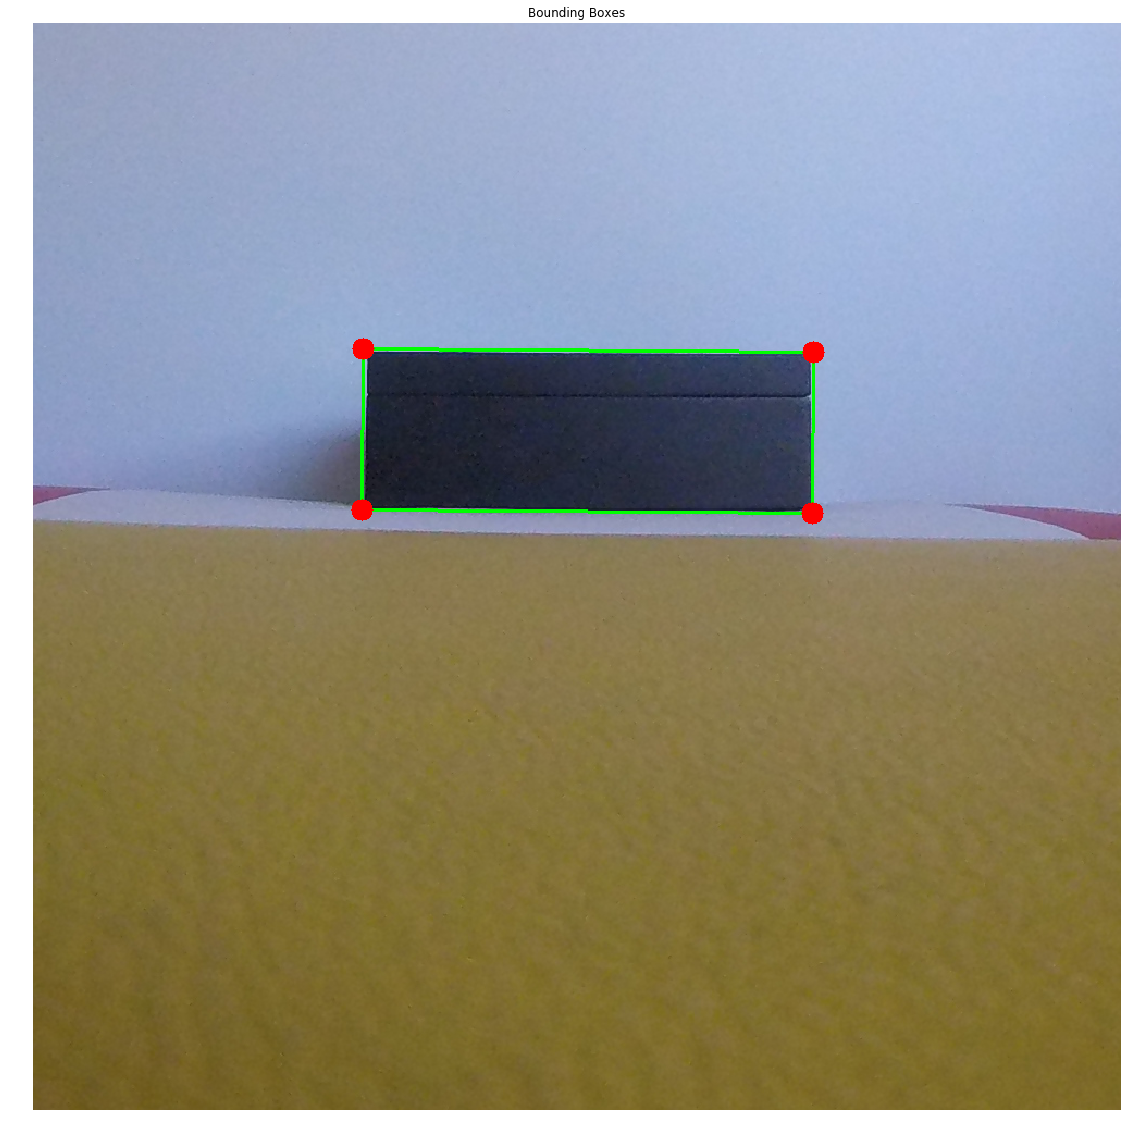

In [331]:
b = boxes_s1[0]
orig = side1.copy()

cv2.drawContours(orig, [b.astype("int")], -1, (0, 255, 0), 2)
for (x, y) in b:
    cv2.circle(orig, (int(x), int(y)), 10, (0, 0, 255), -1)

displayImage(orig, title="Bounding Boxes", figSize=(20,20))

In [334]:
b = boxes_s1[0]
x1 = np.min(b[:,1])
b = boxes_s2[0]
x2 = np.min(b[:,1])

In [335]:
top_b = (wppm2*x1 - wppm1*x2) / (-x2 + x1)
top_m = (wppm1 - top_b) / x1

print(top_b,top_m)


11.9336384688 0.0041337541737


## END OF CALIBRATION OF TOP CAMERA

In [338]:
print(side_b, side_m, top_b, top_m)

20.3059886137 -0.0179589246428 11.9336384688 0.0041337541737


## START OF MEASURING PROCESS

In [337]:
side_b, side_m, top_b, top_m = 20.3059886137, -0.0179589246428, 11.9336384688, 0.0041337541737
def calculatePpm(x, m, b):
    ppm = x*m + b
    return ppm

In [327]:
def calculateSize(img, bg_img, ppm, th):
    diff = cv2.absdiff(bg_img, img)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    imask =  mask>th
    canvas = np.zeros_like(img, np.uint8)
    canvas[:] = 255
    canvas[imask] = img[imask]
    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    result = DoGrayscaleAndBlur(canvas)
    edged = cv2.Canny(result, 180, 200)
    edged = cv2.dilate(edged, None, iterations=2)
    edged = cv2.erode(edged, None, iterations=1)
     # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]

    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts, method='left-to-right')
    
    # get areas for all contours
    areas = []
    for c in cnts:
        a = cv2.contourArea(c)
        areas.append(a)
    
    areas = np.array(areas)
    cnts = np.array(cnts)

    # remove small contours
    cnts = cnts[np.where(areas >= 600)[0]]
    
    # remove areas of removed contours
    areas = areas[np.where(areas >= 600)[0]]
    
    # loop over the contours individually and get bounding boxes
    boxes = []
    for c in cnts:
    
        # compute the rotated bounding box of the contour
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box) 
        box = np.array(box, dtype="int")
 
        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        boxes.append(box)

    boxes = np.array(boxes)
    object_sizes = []

    for box in boxes:
        # unpack the ordered bounding box, then compute the midpoint
        # between the top-left and top-right coordinates, followed by
        # the midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)
 
        # compute the midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-righ and bottom-right
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
 
        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
 
        # compute the size of the object
        dimA = dA / ppm
        dimB = dB / ppm

    return dimA, dimB